In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [2]:
original_dataframe = pd.read_csv("../data/full_import_dataset/full_import_dataset_with_libname.csv", index_col=0)
original_dataframe.head()

,project_name,import,is_kotlin_import,is_python_import,package
0,2dust#v2rayNG,androidx.appcompat.app.AppCompatActivity,1,0,androidx.appcompat
1,2dust#v2rayNG,android.view.MenuItem,1,0,android.view
2,2dust#v2rayNG,android.Manifest,1,0,android
3,2dust#v2rayNG,android.content.Intent,1,0,android.content
4,2dust#v2rayNG,android.net.Uri,1,0,android.net


In [3]:
# Count diff imports of packages in projects
intermediate_dataframe = original_dataframe \
    .groupby(['project_name', 'package']) \
    .agg({'import':'count', 'is_kotlin_import':'first', 'is_python_import':'first'}) \
    .reset_index() \
    .rename(columns={'import':'count_different_import', 'is_kotlin_import':'is_kotlin_package', 'is_python_import':'is_python_package'})

intermediate_dataframe.head()

,project_name,package,count_different_import,is_kotlin_package,is_python_package
0,01joy#news-search-engine,bs4,1,0,1
1,01joy#news-search-engine,datetime,2,0,1
2,01joy#news-search-engine,flask,3,0,1
3,01joy#news-search-engine,index,1,0,1
4,01joy#news-search-engine,jieba,1,0,1


In [4]:
#Check for collision - it's ok
intermediate_dataframe[intermediate_dataframe["is_kotlin_package"] == intermediate_dataframe["is_python_package"]]

,project_name,package,count_different_import,is_kotlin_package,is_python_package


In [5]:
# Drop out 'is_kotlin_package' and 'is_python_package' since there are no collisions

## Package features extraction

In [6]:
# Rename each package name to avoid name collision with tag names
intermediate_dataframe.package = intermediate_dataframe.package.apply(lambda x: f"package#{x}")
intermediate_dataframe.head()

,project_name,package,count_different_import,is_kotlin_package,is_python_package
0,01joy#news-search-engine,package#bs4,1,0,1
1,01joy#news-search-engine,package#datetime,2,0,1
2,01joy#news-search-engine,package#flask,3,0,1
3,01joy#news-search-engine,package#index,1,0,1
4,01joy#news-search-engine,package#jieba,1,0,1


In [7]:
pivot_package_dataframe = intermediate_dataframe.pivot_table(index="project_name", columns="package", values="count_different_import", fill_value=0)
pivot_package_dataframe.head()

package,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,package#APDrawingGAN.models,...,package#zwave_js_server.model.utils,package#zwave_js_server.model.value,package#zwave_js_server.util.command_class,package#zwave_js_server.util.lock,package#zwave_js_server.util.multicast,package#zwave_js_server.util.node,package#zwave_js_server.version,package#zwave_me_ws,package#zxcvbn,package#zypp_plugin
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
pivot_package_dataframe.shape

(2853, 15383)

In [9]:
# So it's ok
pivot_package_dataframe["package#APDrawingGAN.models"].value_counts()

0    2852
1       1
Name: package#APDrawingGAN.models, dtype: int64

## Extencion features extraction

In [10]:
# Load ext count dataset
ext_count_dataset = pd.read_csv("../data/ext_count/full_ext_count_dataset.csv", index_col=0)
ext_count_dataset.head()

,project_name,ext,count
0,donnemartin#gitsome,.yml,4
1,donnemartin#gitsome,NaN,30
2,donnemartin#gitsome,.md,10
3,donnemartin#gitsome,.py,345
4,donnemartin#gitsome,.txt,3


In [11]:
ext_count_dataset.shape

(79546, 3)

In [12]:
ext_count_dataset = ext_count_dataset.dropna()

In [13]:
ext_count_dataset.shape

(75348, 3)

In [14]:
ext_count_dataset.ext = ext_count_dataset.ext.apply(lambda x: f"extension#{x}")
ext_count_dataset.head()

,project_name,ext,count
0,donnemartin#gitsome,extension#.yml,4
2,donnemartin#gitsome,extension#.md,10
3,donnemartin#gitsome,extension#.py,345
4,donnemartin#gitsome,extension#.txt,3
5,donnemartin#gitsome,extension#.ini,1


In [15]:
pivot_ext_count_dataset = ext_count_dataset.pivot_table(index="project_name", columns="ext", values="count", fill_value=0)
pivot_ext_count_dataset.head()

ext,extension#.,extension#.0,extension#.0+,extension#.0-AT,extension#.0-Combined-Work-Exception,extension#.0-DE,extension#.0-FR,extension#.0-IGO,extension#.0-NL,extension#.0-Perl,...,extension#.zktx,extension#.zlib,extension#.zmpl,extension#.zone,extension#.zoneinfo,extension#.zpln,extension#.zraw,extension#.zsh,extension#.zst,extension#.zzz
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
pivot_ext_count_dataset.shape

(3404, 3852)

In [17]:
# So it's ok
pivot_ext_count_dataset["extension#.0-Perl"].value_counts()

0    3403
1       1
Name: extension#.0-Perl, dtype: int64

## Kaggle dataset

In [18]:
# Load kaggle_repos dataframe
kaggle_repos_dataframe = pd.read_csv("../data/kaggle_repos.csv")
kaggle_repos_dataframe.head()

,topic,name,owner,owner_type,full_name,description,og_image,license,is_archived,is_forked,...,open_issues,forks,stars,watchers,has_wiki,has_pages,has_sponsorship,created_at,updated_at,repo
0,3d,SpaceshipGenerator,a1studmuffin,User,a1studmuffin/SpaceshipGenerator,A Blender script to procedurally generate 3D s...,NaN,Other,False,False,...,13,391,7100,7100,True,False,False,2016-06-14T03:16:07Z,2022-04-06T16:55:48Z,https://github.com/a1studmuffin/SpaceshipGener...
1,3d,BlenderGIS,domlysz,User,domlysz/BlenderGIS,NaN,NaN,GNU General Public License v3.0,False,False,...,155,923,5047,5047,True,False,False,2014-05-08T14:48:25Z,2022-04-08T00:59:56Z,https://github.com/domlysz/BlenderGIS
2,3d,PRNet,YadiraF,User,YadiraF/PRNet,Joint 3D Face Reconstruction and Dense Alignme...,NaN,MIT License,False,False,...,160,919,4574,4574,True,False,False,2018-03-20T11:44:06Z,2022-04-08T03:00:19Z,https://github.com/YadiraF/PRNet
3,3d,3DDFA,cleardusk,User,cleardusk/3DDFA,The PyTorch improved version of TPAMI 2017 pap...,NaN,MIT License,False,False,...,51,621,3223,3223,False,False,False,2018-06-29T14:19:21Z,2022-04-07T07:47:09Z,https://github.com/cleardusk/3DDFA
4,3d,armory,armory3d,Organization,armory3d/armory,NaN,NaN,zlib License,False,False,...,310,263,2421,2421,True,False,False,2015-10-29T18:27:56Z,2022-04-06T21:17:40Z,https://github.com/armory3d/armory


In [19]:
kaggle_repos_dataframe.columns

Index(['topic', 'name', 'owner', 'owner_type', 'full_name', 'description',
       'og_image', 'license', 'is_archived', 'is_forked', 'size', 'language',
       'tags', 'open_issues', 'forks', 'stars', 'watchers', 'has_wiki',
       'has_pages', 'has_sponsorship', 'created_at', 'updated_at', 'repo'],
      dtype='object')

In [20]:
# Prepare column for join
kaggle_repos_dataframe["project_name"] = kaggle_repos_dataframe["owner"] + "#" + kaggle_repos_dataframe["name"]
kaggle_repos_dataframe["project_name"].head()

0    a1studmuffin#SpaceshipGenerator
1                 domlysz#BlenderGIS
2                      YadiraF#PRNet
3                    cleardusk#3DDFA
4                    armory3d#armory
Name: project_name, dtype: object

## Repos tags extraction

In [21]:
kaggle_repos_dataframe_tags = kaggle_repos_dataframe[["project_name", "tags"]]
kaggle_repos_dataframe_tags.head()

,project_name,tags
0,a1studmuffin#SpaceshipGenerator,"['python', 'procedural-generation', 'blender-s..."
1,domlysz#BlenderGIS,[]
2,YadiraF#PRNet,"['swap', 'face', 'alignment', 'reconstruction'..."
3,cleardusk#3DDFA,"['python', 'computer-vision', 'deep-learning',..."
4,armory3d#armory,[]


In [22]:
kaggle_repos_dataframe_tags.tags = kaggle_repos_dataframe_tags.tags.apply(ast.literal_eval)
kaggle_repos_dataframe_tags.head()

/tmp/ipykernel_19291/152348957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_repos_dataframe_tags.tags = kaggle_repos_dataframe_tags.tags.apply(ast.literal_eval)


,project_name,tags
0,a1studmuffin#SpaceshipGenerator,"[python, procedural-generation, blender-script..."
1,domlysz#BlenderGIS,[]
2,YadiraF#PRNet,"[swap, face, alignment, reconstruction, 3d]"
3,cleardusk#3DDFA,"[python, computer-vision, deep-learning, pytor..."
4,armory3d#armory,[]


In [23]:
# Prepare dataset for pivot
kaggle_repos_dataframe_tags = kaggle_repos_dataframe_tags.explode("tags")
kaggle_repos_dataframe_tags.head()

,project_name,tags
0,a1studmuffin#SpaceshipGenerator,python
0,a1studmuffin#SpaceshipGenerator,procedural-generation
0,a1studmuffin#SpaceshipGenerator,blender-scripts
0,a1studmuffin#SpaceshipGenerator,game-development
0,a1studmuffin#SpaceshipGenerator,3d


In [24]:
kaggle_repos_dataframe_tags["val"] = 1
kaggle_repos_dataframe_tags.head()

,project_name,tags,val
0,a1studmuffin#SpaceshipGenerator,python,1
0,a1studmuffin#SpaceshipGenerator,procedural-generation,1
0,a1studmuffin#SpaceshipGenerator,blender-scripts,1
0,a1studmuffin#SpaceshipGenerator,game-development,1
0,a1studmuffin#SpaceshipGenerator,3d,1


In [25]:
# Rename each tag name to avoid name collision with package names
kaggle_repos_dataframe_tags.tags = kaggle_repos_dataframe_tags.tags.apply(lambda x: f"tag#{x}")
kaggle_repos_dataframe_tags.head()

,project_name,tags,val
0,a1studmuffin#SpaceshipGenerator,tag#python,1
0,a1studmuffin#SpaceshipGenerator,tag#procedural-generation,1
0,a1studmuffin#SpaceshipGenerator,tag#blender-scripts,1
0,a1studmuffin#SpaceshipGenerator,tag#game-development,1
0,a1studmuffin#SpaceshipGenerator,tag#3d,1


In [26]:
# Total number of tags
kaggle_repos_dataframe_tags.tags.unique().size

9148

In [27]:
kaggle_repos_dataframe_tags.project_name.unique().size

3418

In [28]:
pivot_tags_dataframe = kaggle_repos_dataframe_tags.pivot_table(index="project_name", values="val", columns="tags", fill_value=0)
pivot_tags_dataframe.head()

tags,tag#010editor,tag#053,tag#0day,tag#100daysofcode,tag#104,tag#1111,tag#12306,tag#163mail-login,tag#2,tag#2019-ncov,...,tag#zircon,tag#zookeeper,tag#zoom,tag#zotero,tag#zotero-api,tag#zsh,tag#ztp,tag#zuul,tag#zvt,tag#zypper
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
set(pivot_tags_dataframe.columns).difference(set(kaggle_repos_dataframe.tags.unique()))

{'tag#postgresql-driver',
 'tag#blocks',
 'tag#thehive4',
 'tag#opentype',
 'tag#dagger2-mvvm',
 'tag#datajournalism',
 'tag#chainid',
 'tag#deep-learning-deploy',
 'tag#python-social-auth',
 'tag#metasploit',
 'tag#data-gathering',
 'tag#homebrew',
 'tag#dcim',
 'tag#waifu2x',
 'tag#best',
 'tag#nfm',
 'tag#arxiv-papers',
 'tag#cloud-cost-intelligence',
 'tag#bintray',
 'tag#spam',
 'tag#estimator',
 'tag#text-processing',
 'tag#conferences',
 'tag#statusline',
 'tag#spacy-extension',
 'tag#adblock',
 'tag#datastore-android',
 'tag#becoming-an-expert',
 'tag#cross-lingual',
 'tag#polyglot-files',
 'tag#braintree',
 'tag#cross-modal-retrieval',
 'tag#hail',
 'tag#android-mvi',
 'tag#finops',
 'tag#tensorforce',
 'tag#serializer',
 'tag#aws-apigateway',
 'tag#autonomous-vehicles',
 'tag#gpo',
 'tag#system-control',
 'tag#supervisor',
 'tag#osquery',
 'tag#character-level-cnn',
 'tag#dtw',
 'tag#terraform',
 'tag#mujoco',
 'tag#documentation-generator',
 'tag#mockk',
 'tag#containerd',
 

In [30]:
pivot_tags_dataframe.shape

(3418, 9148)

In [31]:
# Check values
pivot_tags_dataframe["tag#haskell"].value_counts()

0    3413
1       5
Name: tag#haskell, dtype: int64

In [32]:
# all tags exist at least once
pivot_tags_dataframe.apply(lambda x: x.sum()).sort_values()

tags
tag#010editor                 1
tag#okhttp3-integration       1
tag#okhttp-interceptor        1
tag#okhttp-client             1
tag#okex-api                  1
                           ... 
tag#deep-learning           234
tag#django                  246
tag#machine-learning        279
tag#nan                     473
tag#python                 1279
Length: 9148, dtype: int64

## Repos topics extraction

In [33]:
kaggle_repos_dataframe_topics = kaggle_repos_dataframe[["project_name", "topic"]]
kaggle_repos_dataframe_topics.head()

,project_name,topic
0,a1studmuffin#SpaceshipGenerator,3d
1,domlysz#BlenderGIS,3d
2,YadiraF#PRNet,3d
3,cleardusk#3DDFA,3d
4,armory3d#armory,3d


In [34]:
kaggle_repos_dataframe_topics["val"] = 1
kaggle_repos_dataframe_topics.head()

/tmp/ipykernel_19291/2898533846.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_repos_dataframe_topics["val"] = 1


,project_name,topic,val
0,a1studmuffin#SpaceshipGenerator,3d,1
1,domlysz#BlenderGIS,3d,1
2,YadiraF#PRNet,3d,1
3,cleardusk#3DDFA,3d,1
4,armory3d#armory,3d,1


In [35]:
kaggle_repos_dataframe_topics.topic = kaggle_repos_dataframe_topics.topic.apply(lambda x: f"topic#{x}")
kaggle_repos_dataframe_topics.head()

/tmp/ipykernel_19291/1026092792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kaggle_repos_dataframe_topics.topic = kaggle_repos_dataframe_topics.topic.apply(lambda x: f"topic#{x}")


,project_name,topic,val
0,a1studmuffin#SpaceshipGenerator,topic#3d,1
1,domlysz#BlenderGIS,topic#3d,1
2,YadiraF#PRNet,topic#3d,1
3,cleardusk#3DDFA,topic#3d,1
4,armory3d#armory,topic#3d,1


In [36]:
pivot_topics_dataframe = kaggle_repos_dataframe_topics.pivot_table(index="project_name", values="val", columns="topic", fill_value=0)
pivot_topics_dataframe.head()

topic,topic#3d,topic#ajax,topic#algorithm,topic#android,topic#angular,topic#ansible,topic#api,topic#arduino,topic#aspnet,topic#atom,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Final dataset construction

In [37]:
# Final step - join package columns (features) and tags columns (targets)

In [38]:
# First of all check size of dataframes
pivot_tags_dataframe.shape

(3418, 9148)

In [39]:
pivot_topics_dataframe.shape

(3418, 161)

In [40]:
pivot_package_dataframe.shape

(2853, 15383)

In [41]:
pivot_ext_count_dataset.shape

(3404, 3852)

In [42]:
set(pivot_tags_dataframe.index).difference(set(pivot_package_dataframe.index))

{'1N3#Wordpress-XMLRPC-Brute-Force-Exploit',
 '666wcy#ARPT-Bot',
 'Ank-Cha#Social-Distancing-Analyser-COVID-19',
 'Bhupesh-V#memer-action',
 'CLUEbenchmark#CLUEDatasetSearch',
 'CiKu370#OSIF',
 'Comcast#ansible-sdkman',
 'Dineshkarthik#telegram_media_downloader',
 'DmrfCoder#AlgorithmAndDataStructure',
 'EZFNDEV#EZFN-Lobbybot',
 'EZForever#HiveMiner',
 'FeeiCN#Security-PPT',
 'Hello-Linux#Ansible-VIM-IDE',
 'HoboVR-Labs#hobo_vr',
 'INTERMT#Awesome-PyTorch-Chinese',
 'Jack-Cherish#PythonPark',
 'JalanJiang#leetcode-notebook',
 'Karan-Malik#FaceMaskDetector',
 'Kylmakalle#heroku-telegram-bot',
 'LyleMi#Learn-Web-Hacking',
 'MMehdiMousavi#SuperCaustics',
 'Nanoseb#ncTelegram',
 'Neko250#sublime-PICO-8',
 'Panintelligence#picons',
 'RunaCapital#awesome-oss-alternatives',
 'RyanAWalters#PowerOf2ImageResizer',
 'Singosgu#GreaterWMS',
 'SpEcHiDe#AnyDLBot',
 'SpectralVectors#RightMouseNavigation',
 'TarrySingh#Artificial-Intelligence-Deep-Learning-Machine-Learning-Tutorials',
 'Tautulli#Tautul

In [43]:
set(pivot_tags_dataframe.columns).intersection(set(pivot_package_dataframe.columns))

set()

In [44]:
# Check for package names and tag names intersection
set(pivot_topics_dataframe.columns).intersection(set(pivot_package_dataframe.columns))

set()

In [45]:
set(pivot_tags_dataframe.columns).intersection(set(pivot_ext_count_dataset.columns))

set()

In [46]:
set(pivot_package_dataframe.columns).intersection(set(pivot_ext_count_dataset.columns))

set()

In [47]:
final_dataset = pivot_package_dataframe.join(pivot_ext_count_dataset, on="project_name", how="inner")
final_dataset.head()

,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,package#APDrawingGAN.models,...,extension#.zktx,extension#.zlib,extension#.zmpl,extension#.zone,extension#.zoneinfo,extension#.zpln,extension#.zraw,extension#.zsh,extension#.zst,extension#.zzz
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
final_dataset = final_dataset.join(pivot_tags_dataframe, on="project_name", how="inner")
final_dataset.head()

,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,package#APDrawingGAN.models,...,tag#zircon,tag#zookeeper,tag#zoom,tag#zotero,tag#zotero-api,tag#zsh,tag#ztp,tag#zuul,tag#zvt,tag#zypper
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
final_dataset = final_dataset.join(pivot_topics_dataframe, on="project_name", how="inner")
final_dataset.head()

,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,package#APDrawingGAN.models,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
project_name,,,,,,,,,,,,,,,,,,,,,
01joy#news-search-engine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
05bit#peewee-async,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0k#shyaml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xAX#linux-insides,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
final_dataset.shape

(2853, 28544)

In [51]:
pivot_tags_dataframe.shape[1] + pivot_package_dataframe.shape[1] + pivot_ext_count_dataset.shape[1] + pivot_topics_dataframe.shape[1]

28544

In [52]:
final_dataset.reset_index(inplace=True)

In [53]:
final_dataset.head()

,project_name,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Final dataset postprocessing

# Filtering tags

In [54]:
old_tags = [c for c in final_dataset.columns if c.startswith('tag')]
len(old_tags)

9148

In [55]:
tags_dataset = final_dataset[old_tags]
tags_dataset.head()

,tag#010editor,tag#053,tag#0day,tag#100daysofcode,tag#104,tag#1111,tag#12306,tag#163mail-login,tag#2,tag#2019-ncov,...,tag#zircon,tag#zookeeper,tag#zoom,tag#zotero,tag#zotero-api,tag#zsh,tag#ztp,tag#zuul,tag#zvt,tag#zypper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
def build_count_tags_usage_dataset(tags_data):
    return tags_data.apply(lambda x: x.sum()).reset_index().rename(columns={0:"count"})

In [57]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#010editor,0
1,tag#053,1
2,tag#0day,1
3,tag#100daysofcode,1
4,tag#104,1


There are many zeros - need to filter it

In [58]:
count_tags_usage_dataset.sort_values(by=["count"])

,index,count
0,tag#010editor,0
2818,tag#fastcgi,0
3543,tag#guideline,0
937,tag#bottles-versioning,0
936,tag#bottles,0
...,...,...
1999,tag#deep-learning,205
2212,tag#django,237
4662,tag#machine-learning,257
5254,tag#nan,413


In [59]:
count_tags_usage_dataset[count_tags_usage_dataset["count"] == 0].shape

(1084, 2)

In [60]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] != 0]["index"]]
tags_dataset.shape

(2853, 8064)

In [61]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#053,1
1,tag#0day,1
2,tag#100daysofcode,1
3,tag#104,1
4,tag#1111,1


In [62]:
# there is nan tag - should be filtered
count_tags_usage_dataset = count_tags_usage_dataset.sort_values(by=["count"],ascending=False)
count_tags_usage_dataset.head()

,index,count
5642,tag#python,1089
4652,tag#nan,413
4121,tag#machine-learning,257
1932,tag#django,237
1746,tag#deep-learning,205


In [63]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["index"] != "tag#nan"]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#hamming-distance,tag#hail,tag#hacs,tag#hacks,tag#hackintosh,tag#hackerrank,tag#hackerone,tag#hacker-news-reader,tag#hacker-news-client,tag#zypper
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1089
1,tag#machine-learning,257
2,tag#django,237
3,tag#deep-learning,205
4,tag#tensorflow,176


In [65]:
# check value counts
value_counts = count_tags_usage_dataset["count"].value_counts()
value_counts

1      5827
2      1029
3       382
4       215
5       131
       ... 
44        1
42        1
38        1
257       1
37        1
Name: count, Length: 69, dtype: int64

<AxesSubplot:>

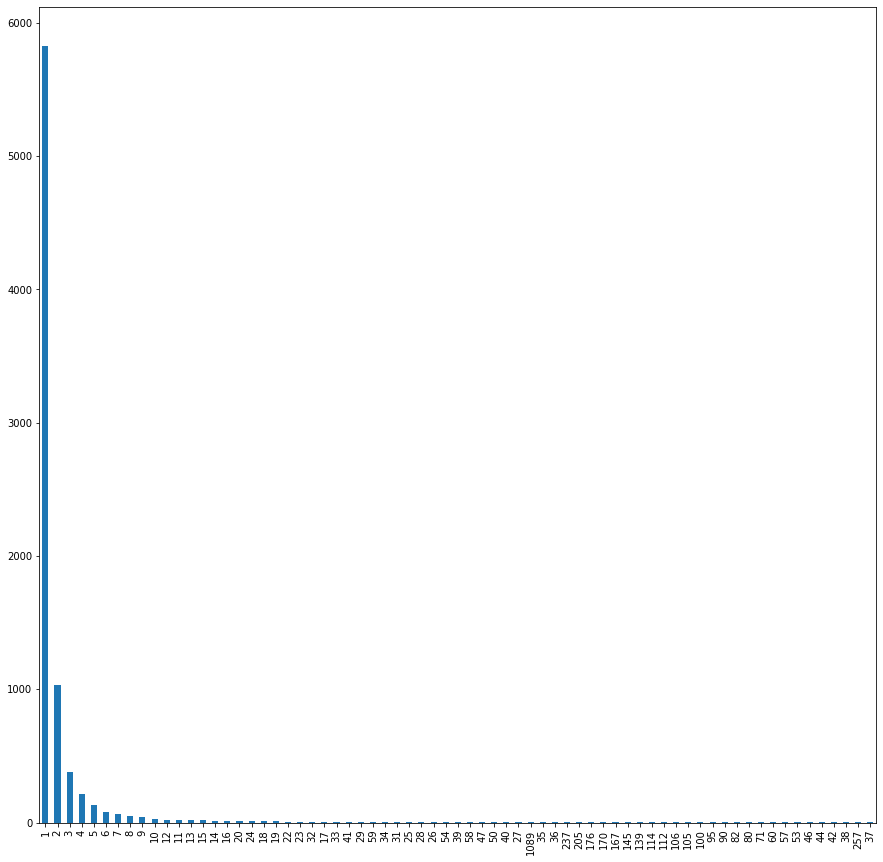

In [66]:
# take a look on bar chart of value counts
value_counts.plot.bar(figsize=(15,15))

In [67]:
# try to filter tags which count less than 5
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1089
1,tag#machine-learning,257
2,tag#django,237
3,tag#deep-learning,205
4,tag#tensorflow,176


In [68]:
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] >= 5]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#androidx,tag#style-transfer,tag#plotly-dash,tag#rxjava,tag#fuzzing,tag#asynchronous,tag#bilibili,tag#api-wrapper,tag#jinja2,tag#flow
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
count_tags_usage_dataset = build_count_tags_usage_dataset(tags_dataset)
count_tags_usage_dataset.head()

,index,count
0,tag#python,1089
1,tag#machine-learning,257
2,tag#django,237
3,tag#deep-learning,205
4,tag#tensorflow,176


<AxesSubplot:>

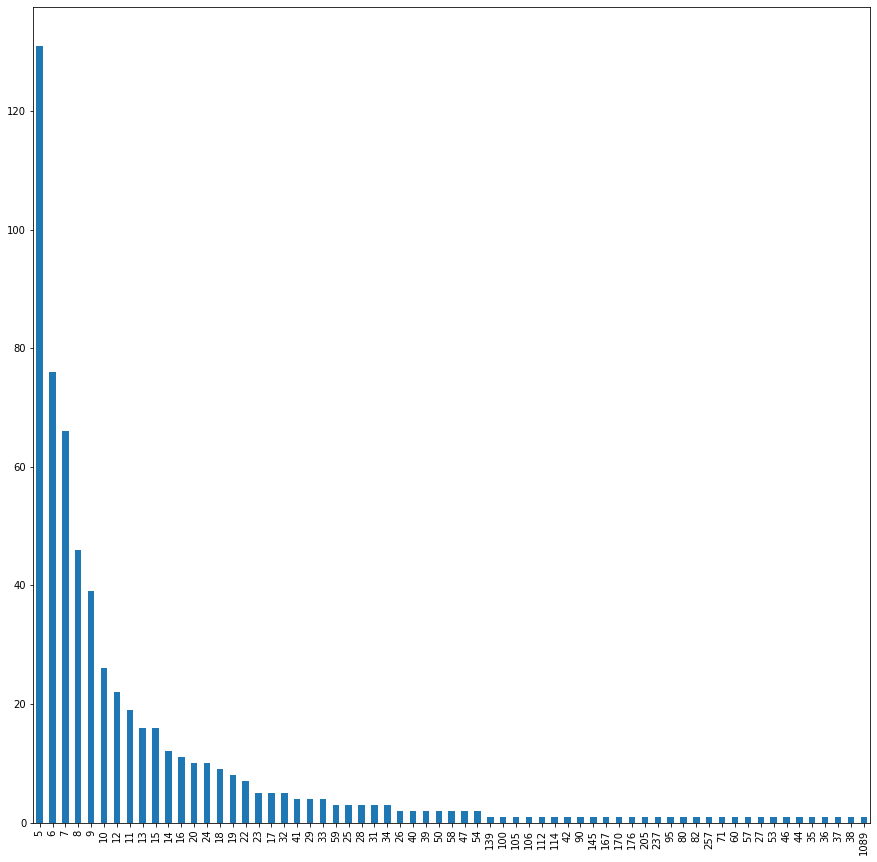

In [70]:
# check bar chart of value counts again
count_tags_usage_dataset["count"].value_counts().plot.bar(figsize=(15,15))

In [71]:
# I like count 10, lets filter tags with count less than 10
tags_dataset = tags_dataset[count_tags_usage_dataset[count_tags_usage_dataset["count"] >= 10]['index']]
tags_dataset.head()

,tag#python,tag#machine-learning,tag#django,tag#deep-learning,tag#tensorflow,tag#python3,tag#flask,tag#kotlin,tag#android,tag#hacktoberfest,...,tag#virtual-reality,tag#pretrained-models,tag#wechat,tag#matplotlib,tag#tools,tag#nginx,tag#word2vec,tag#github-actions,tag#graph,tag#c
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Lets check the rest of tags - looks good to me
tags_dataset.columns.tolist()

['tag#python',
 'tag#machine-learning',
 'tag#django',
 'tag#deep-learning',
 'tag#tensorflow',
 'tag#python3',
 'tag#flask',
 'tag#kotlin',
 'tag#android',
 'tag#hacktoberfest',
 'tag#bot',
 'tag#nlp',
 'tag#scikit-learn',
 'tag#pytorch',
 'tag#docker',
 'tag#telegram',
 'tag#linux',
 'tag#data-science',
 'tag#security',
 'tag#cryptocurrency',
 'tag#gradle',
 'tag#api',
 'tag#cli',
 'tag#java',
 'tag#natural-language-processing',
 'tag#keras',
 'tag#computer-vision',
 'tag#google',
 'tag#jupyter-notebook',
 'tag#bitcoin',
 'tag#aws',
 'tag#library',
 'tag#javascript',
 'tag#ansible',
 'tag#testing',
 'tag#github-api',
 'tag#covid-19',
 'tag#data-visualization',
 'tag#wagtail',
 'tag#algorithm',
 'tag#neural-network',
 'tag#windows',
 'tag#json',
 'tag#git',
 'tag#telegram-bot',
 'tag#twitter',
 'tag#terminal',
 'tag#font',
 'tag#ubuntu',
 'tag#pandas',
 'tag#automation',
 'tag#framework',
 'tag#rest-api',
 'tag#web',
 'tag#jupyter',
 'tag#ethereum',
 'tag#parsing',
 'tag#monitoring',


In [73]:
new_tags = tags_dataset.columns

In [74]:
# generate new columns of final dataset
new_final_dataset_columns = [c for c in final_dataset.columns if not c.startswith('tag') or c in new_tags]

In [75]:
final_dataset.shape

(2853, 28545)

In [76]:
final_dataset = final_dataset[new_final_dataset_columns]

In [77]:
# new shape
final_dataset.shape

(2853, 19649)

In [78]:
final_dataset.head()

,project_name,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Filter projects which hasn't any tag form our new tag set

In [79]:
# Count such unlucky projects
final_dataset[new_tags].sum(1).value_counts()

3     571
2     547
0     439
4     390
1     316
5     267
6     147
7      65
8      45
9      28
10     24
12      5
13      5
11      3
14      1
dtype: int64

In [80]:
# So we have 439 projects without any tag from our new tag set
# And we have two options:
# First - leave it untouched and fit classifier on full negative projects too
# Second - filter it
# So hard choice :)

In [81]:
# Lets leave it as it is for now

# Export final dataset

In [82]:
final_dataset.head()

,project_name,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
final_dataset.shape

(2853, 19649)

In [84]:
final_dataset.to_csv("../data/classification/count_dataset_for_multilabel.csv", index=False)

In [85]:
final_columns = final_dataset.columns.to_list()

In [86]:
final_columns = [col for col in final_columns if not col.startswith("tag") and not col.startswith("topic")]

In [87]:
final_columns = pd.DataFrame(final_columns, columns=["column_name"])
final_columns

,column_name
0,project_name
1,package#A
2,package#ACGAN
3,package#APDrawing
4,package#APDrawingGAN
...,...
19231,extension#.zpln
19232,extension#.zraw
19233,extension#.zsh
19234,extension#.zst


In [88]:
final_columns.to_csv("../data/pipeline/final_columns.csv", index=False)

In [94]:
final_tags = []
for tag in final_dataset.columns.to_list():
    if tag.startswith("tag#"):
        final_tags.append(tag.split("tag#")[1])
    if tag.startswith("topic#"):
        final_tags.append(tag.split("topic#")[1])

In [95]:
final_tags = pd.DataFrame(final_tags, columns=["tag_name"])
final_tags

,tag_name
0,3d
1,ai
2,algorithm
3,algorithmic-trading
4,algorithms
...,...
408,webapp
409,webpack
410,windows
411,wordpress


In [96]:
final_tags.to_csv("../data/pipeline/final_tags.csv", index=False)